## 1. 라이브러리 설치

In [1]:
!pip install torch torchvision
!pip install retinaface-pytorch opencv-python datasets

  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)
Using cached pydantic-2.9.2-py3-none-any.whl (434 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.8
    Uninstalling pydantic-1.10.8:
      Successfully uninstalled pydantic-1.10.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-cloud-auth 0.1.3 requires pydantic<2.0, but you have pydantic 2.9.2 which is incompatible.


## 2. 모델 로드 테스트

In [90]:
import torch
import torchvision.models as models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# # 사전 학습된 ResNet50 모델 다운로드
# model = models.resnet50(pretrained=True)

# 객체 감지 모델 로드 (사전 학습된 Faster R-CNN)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# CUDA 사용 설정 (GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("ResNet50 모델이 성공적으로 로드되었습니다.")

/home/sshsys/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sshsys/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50 모델이 성공적으로 로드되었습니다.


## 3. ResNet50 모델을 사용한 이미지 추론

In [110]:
import cv2

# COCO 데이터셋 클래스 이름 로드 (사전 학습된 모델 기준)
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
    'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# OpenCV로 바운딩 박스 그리기
def draw_boxes_on_image(image_path, boxes, labels, scores, threshold=0.3):
    # OpenCV로 이미지를 로드
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR을 사용하므로 RGB로 변환

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = map(int, box)
        if score < threshold:
            continue
        
        class_name = COCO_INSTANCE_CATEGORY_NAMES[label]
        # 바운딩 박스 그리기
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # 빨간색 박스
        # 클래스 이름과 점수 텍스트 추가
        cv2.putText(image, f'{class_name}: {score:.2f}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    
    # cv2.imwrite('output.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # OpenCV는 RGB를 사용하므로 BGR로 변환하여 저장
    return image

## 4. 시각화

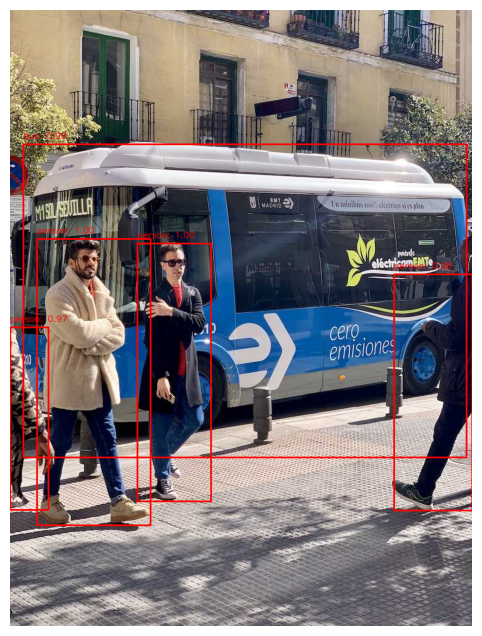

In [114]:
import matplotlib.pyplot as plt

from torchvision import transforms
from PIL import Image

preprocess = transforms.Compose([
    transforms.ToTensor(),
])

# 이미지 로드 및 전처리
image = Image.open("bus.jpg")
img_tensor = preprocess(image)
img_tensor = img_tensor.unsqueeze(0)  # 배치 차원 추가 (1, 3, 224, 224)

# 추론 수행
model.eval()
with torch.no_grad():
    img_tensor = img_tensor.to(device)
    outputs = model(img_tensor)

# 결과 해석
output = outputs[0]
boxes = output['boxes'].cpu().numpy()  # 바운딩 박스 좌표 (x1, y1, x2, y2)
labels = output['labels'].cpu().numpy()  # 탐지된 클래스 인덱스
scores = output['scores'].cpu().numpy()  # 탐지된 객체의 신뢰도 점수

# 이미지에 바운딩 박스 그리기
image_with_boxes = draw_boxes_on_image("bus.jpg", boxes, labels, scores, threshold=0.5)

# Matplotlib을 사용하여 이미지 시각화
plt.figure(figsize=(10, 8))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()

## 5. 모델 저장

In [116]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')